# **Set up**

In [ ]:
from pyspark import SparkContext
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from pyspark.sql.functions import *
from pyspark.sql.types import BooleanType
from datetime import datetime
import holidays
import plotly.express as px
import plotly.graph_objects as go
from plotly.graph_objs import Scatter3d, Figure
from sklearn.linear_model import LinearRegression

Mounted at /content/drive


In [ ]:
# Install dependencies
#!apt-get update
#!apt-get install openjdk-11-jdk -y
#!pip install pyspark==3.3.0
#!pip install synapseml

## Spark session required for working with Isolation Forest

from pyspark.sql import SparkSession
#sc = SparkContext(appName="SPARK-BASICS", master="local[*]")
# Set up SparkSession with SynapseML
spark = SparkSession.builder \
    .appName("SynapseMLIsolationForest") \
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.0") \
    .getOrCreate()

'''
# Import necessary libraries
from pyspark.sql import SparkSession
from google.colab import drive
drive.mount('/content/drive')

# Set up SparkSession with SynapseML
spark = SparkSession.builder \
    .appName("SynapseMLIsolationForest") \
    .getOrCreate()
'''

sc = spark.sparkContext

In [ ]:
file_path = '/content/drive/MyDrive/DDAM Group 2/credit_card_transaction_train.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)
df_income = spark.read.csv('/content/drive/MyDrive/DDAM Group 2/income_by_household.csv', header=True, inferSchema=True)

In [ ]:
# Importing data about the avg. household incom by state for the two years
df_income = df_income.withColumnRenamed('State', 'state')
df_income = df_income.withColumnRenamed('nineteen', 'Income_2019')
df_income = df_income.withColumnRenamed('twenty', 'Income_2020')

df = df.join(df_income, on='state', how='left') # final dataset with two more columns

# **EDA**

In [ ]:
# This may be usefull for computing the avg number of transaction per day of each user
print(f'How many days were considered in the df:\
 {datetime(2020, 6, 21, 12, 13, 37) - datetime(2019, 1, 1, 0, 0, 18)}')
print(f'Percentage of trnsaction below 1000$: {(df.filter("amt < 1000").count()/df.count())*100:.2f} %')
print(f'Percentage of fraudolent transaction below 1000$: {(df.filter("is_fraud = 1").count()/df.count())*100:.2f} %')

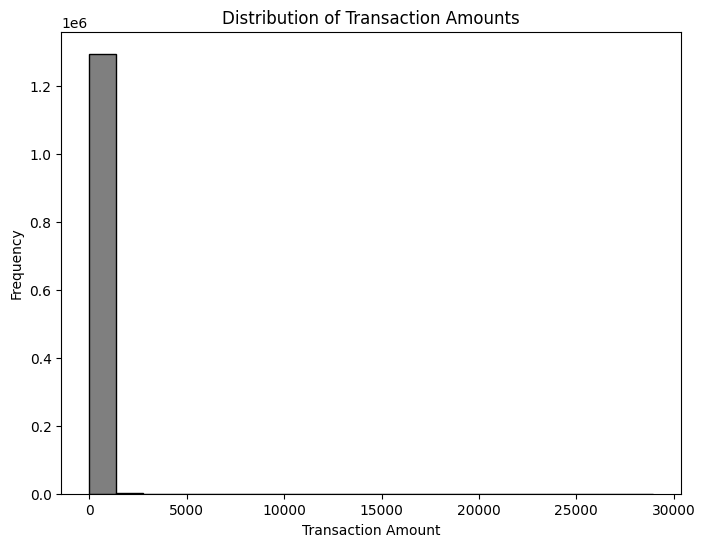

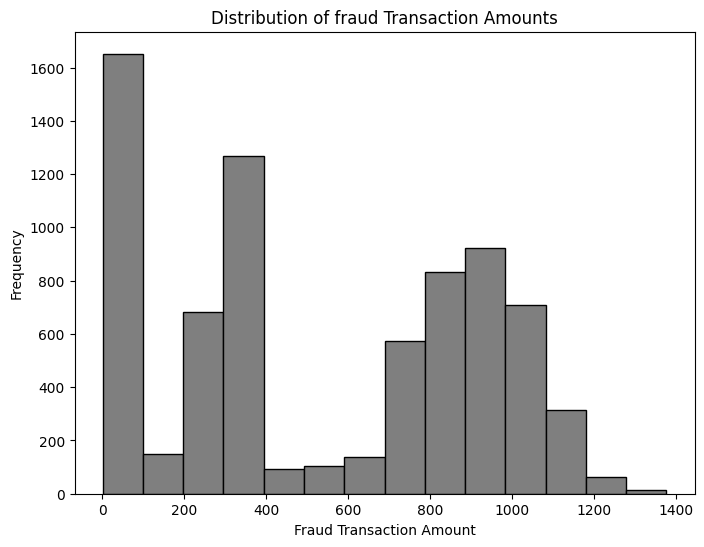

In [ ]:
amount_data = df.select("amt").toPandas()["amt"]

plt.figure(figsize=(8, 6))
plt.hist(amount_data, bins=21, color=colors['Grey'], edgecolor="black")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.title("Distribution of Transaction Amounts")
plt.show()

# It is almost a bimodal distribution
fraud_amt_df = df.filter("is_fraud = 1").select('amt').toPandas()['amt']

plt.figure(figsize=(8, 6))
plt.hist(fraud_amt_df, bins=14, color=colors['Grey'], edgecolor="black")
plt.xlabel("Fraud Transaction Amount")
plt.ylabel("Frequency")
plt.title("Distribution of fraud Transaction Amounts")
plt.show()

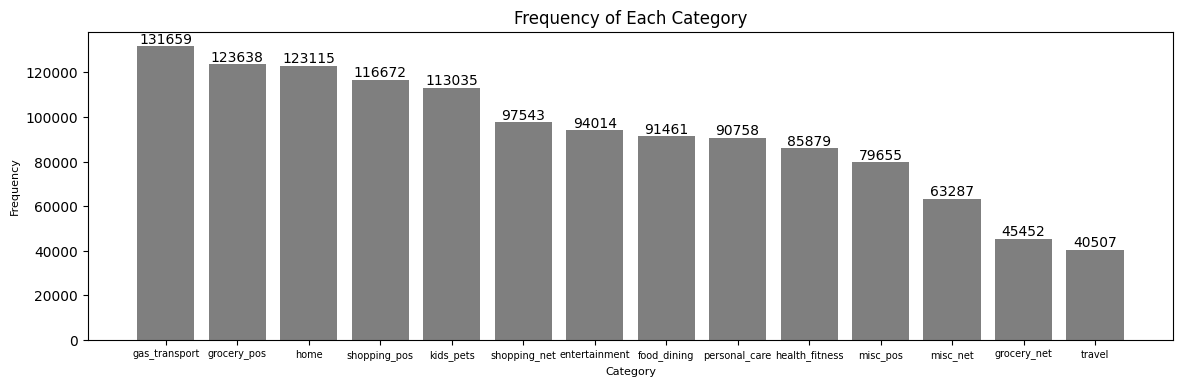

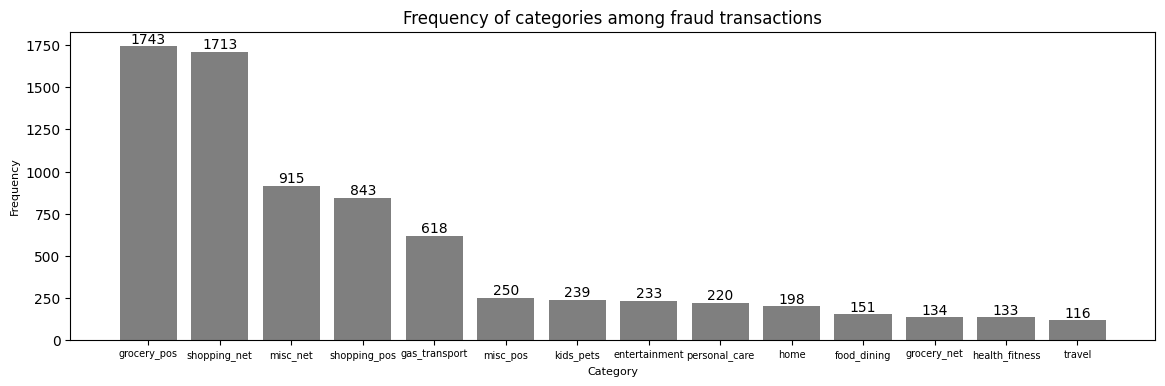

In [ ]:
# Number of transaction for each category
df_pd = df.groupBy("category").count().alias('count').orderBy('count', ascending = False).toPandas()

plt.figure(figsize=(14, 4))
bars = plt.bar(df_pd["category"], df_pd["count"], color=colors['Grey'])
plt.xlabel("Category", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.title("Frequency of Each Category")
plt.xticks(fontsize=7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, int(height),
             ha='center', va='bottom')
plt.show()

# Number of FRAUD transaction for each category
fraud_df = df.filter("is_fraud = 1")
fraud_df_pd = fraud_df.groupBy("category").count().alias('count').orderBy('count', ascending = False).toPandas()

plt.figure(figsize=(14, 4))
bars = plt.bar(fraud_df_pd["category"], fraud_df_pd["count"], color=colors['Grey'])
plt.xlabel("Category", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.title("Frequency of categories among fraud transactions")
plt.xticks(fontsize=7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, int(height),
             ha='center', va='bottom')
plt.show()

In [ ]:
# max spent per category
df.groupBy("category").max('amt').orderBy('max(amt)', ascending = False).show()

+--------------+--------+
|      category|max(amt)|
+--------------+--------+
|        travel| 28948.9|
|  shopping_pos| 9754.72|
|  shopping_net| 9555.26|
|      misc_net| 4084.34|
|      misc_pos| 2703.62|
| entertainment|  934.47|
|   food_dining|  769.26|
|health_fitness|  598.38|
|     kids_pets|  586.34|
|          home|  560.81|
| personal_care|  527.03|
|   grocery_pos|  397.97|
|   grocery_net|  185.81|
| gas_transport|  154.03|
+--------------+--------+



In [ ]:
# At cumulative level the cat that absorbe more money is grocery_pos
df.groupBy("category").sum('amt').orderBy('sum(amt)', ascending = False).show()

+--------------+--------------------+
|      category|            sum(amt)|
+--------------+--------------------+
|   grocery_pos|1.4460822379999954E7|
|  shopping_pos|   9307993.610000012|
|  shopping_net|    8625149.67999999|
| gas_transport|   8351732.290000033|
|          home|   7173928.110000001|
|     kids_pets|  6503680.1600000225|
| entertainment|   6036678.560000032|
|      misc_net|    5117709.26000002|
|      misc_pos|   5009582.500000005|
|   food_dining|   4672459.440000015|
|health_fitness|   4653108.020000027|
|        travel|   4516721.679999998|
| personal_care|   4353450.530000006|
|   grocery_net|          2439412.68|
+--------------+--------------------+



In [ ]:
# For each card how many cardholders? Max 1!!
df.groupBy('cc_num').agg(countDistinct('first','last').alias('distinct_firsts')).orderBy('distinct_firsts', ascending=False).show(1)

+-------------------+---------------+
|             cc_num|distinct_firsts|
+-------------------+---------------+
|4798937978667559470|              1|
+-------------------+---------------+
only showing top 1 row



In [ ]:
# For every cardholder, how many cc ? Max 1!!
df.groupBy('last', 'first', 'lat').agg(countDistinct('cc_num').alias('distinct_cc')).orderBy('distinct_cc', ascending=False).show(1)

+---------+-------+------------------+-----------+
|     last|  first|               lat|distinct_cc|
+---------+-------+------------------+-----------+
|Robertson|Phillip|39.013000000000005|          1|
+---------+-------+------------------+-----------+
only showing top 1 row



In [ ]:
print(f'Total distinct number of credit cards: {len(df.select("cc_num").distinct().collect())}')
df.agg(min(df['trans_date_trans_time']).alias('Oldest transaction'),
       max(df['trans_date_trans_time']).alias('Newest transaction')).show()

+-------------------+-------------------+
| Oldest transaction| Newest transaction|
+-------------------+-------------------+
|2019-01-01 00:00:18|2020-06-21 12:13:37|
+-------------------+-------------------+



# **Data preparation**

Missing values; Columns Pre-processing, Duplicates



In [ ]:
# Replace 'dob' with 'age'
df = df.withColumn('age', (year(current_date()) - year(col('dob'))))

# Replace gender M == 0; F == 1
df = df.withColumn('gender', when(col('gender') == 'M', 0).when(col('gender') == 'F', 1))
df = df.drop('dob')

# Split the trans_date_trans_time in
df = df.withColumn('year', year(col('trans_date_trans_time')))
df = df.withColumn('month', month(col('trans_date_trans_time')))
df = df.withColumn('day', dayofmonth(col('trans_date_trans_time')))
df = df.withColumn('hour', hour(col('trans_date_trans_time')))
df = df.withColumn('minute', minute(col('trans_date_trans_time')))
df = df.withColumn('second', second(col('trans_date_trans_time')))
df = df.drop('trans_date_trans_time')
df = df.drop("unix_time", "first", "last", "zip_merchant")
df = df.withColumn("merchant", regexp_replace("merchant", "^fraud_", "")) # all the merchant's name started with "fraud_"

In [ ]:
# Creating a broadcast variable for U.S. holidays
years = df.select("year").distinct().rdd.flatMap(lambda x: x).collect()
us_holidays = holidays.US(years=years)
broadcast_holidays = sc.broadcast(us_holidays)

def is_holiday(year, month, day):
    try:
        date_str = f"{year:04d}-{month:02d}-{day:02d}"
        return date_str in broadcast_holidays.value
    except:
        return False

is_holiday_udf = udf(is_holiday, BooleanType())
df = df.withColumn('is_holiday',is_holiday_udf(col('year'), col('month'), col('day')))
df = df.withColumn('is_holiday', when(col('is_holiday') == 'True', 0).when(col('is_holiday') == 'False', 1))

In [ ]:
# Calculate the number of transactions per credit card
no_transactions_by_cc = df.groupBy('cc_num').agg(count('*').alias('num_of_transactions'))
df = df.join(no_transactions_by_cc, on='cc_num', how='left')
df = df.withColumn('daily_tran', round((col('num_of_transactions')/537),2))
df = df.drop('num_of_transactions')

# AVG daily spent by cc_num
avg_spent_by_cc = df.groupBy('cc_num').agg(sum('amt').alias('sum_amt'))
avg_spent_by_cc = avg_spent_by_cc.withColumn('daily_avg_spent', round((col('sum_amt')/537),2)) #537 days considered in the DF
avg_spent_by_cc = avg_spent_by_cc.drop('sum_amt')
df = df.join(avg_spent_by_cc, on='cc_num', how='left')

In [ ]:
# Computing the total spent by category (for each card)
df_total_spent = df.groupBy('cc_num', 'category').agg(round(sum('amt'), 2).alias('total_spent'))
categories = df.select('category').distinct().rdd.flatMap(lambda x: x).collect()
df_total_spent = df_total_spent.groupBy('cc_num').pivot('category').agg(first('total_spent'))
df = df.join(df_total_spent, on='cc_num', how='left')
df = df.drop('total_spent')

**Frequency encoding + smoothing**

Instead of one-hot encoding I replaced **categories** and **states** with the smoothed frequence, based on their presence in the dataset. The smoothing params is usefule because otherwise, if one class is more represented than another this may lead to unintended behaviours.

In [ ]:
category_counts = df.groupBy("category").count()
df = df.join(category_counts, on="category", how="left")

total_count = df.count()
num_categories = df.select("category").distinct().count() # num of unique cat

alpha = 1  # Smoothing parameter (hyperparam)

df = df.withColumn("cat_enc", round((df['count'] + alpha) / (total_count + alpha * num_categories), 5))

df = df.drop('count')

category_counts = df.groupBy("state").count()
df = df.join(category_counts, on="state", how="left")

num_categories = df.select("state").distinct().count()


df = df.withColumn("st_enc", round((df["count"] + alpha) / (total_count + alpha * num_categories), 5))
df = df.drop('count')

#**Pre-processing and clustering analysis**

Clustering may involves different level of granularity: clustering of customers and clustering of transactions





In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import seaborn as sns
from synapse.ml.isolationforest import IsolationForest
from pyspark.ml.feature import VectorAssembler

#### Creating more features for clustering

In [ ]:
# Creating a df about cardholders
df_cu = df.groupBy('cc_num').count()
df_cu = df_cu.drop('count')


df_for_customers = df.select(
    'cc_num','age','gender','st_enc',
    'zip', 'lat','long','job','city_pop',
    'daily_tran','daily_avg_spent','travel',
    'misc_net','grocery_pos','kids_pets','shopping_net',
    'grocery_net','food_dining','gas_transport',
    'personal_care','health_fitness', 'entertainment',
    'home','misc_pos','shopping_pos','Income_2019','Income_2020')

df_for_customers = df_for_customers.dropDuplicates(['cc_num'])

# Transactions during the holidays
df_num_trans_in_holidays = df.filter('is_holiday = 1').groupBy('cc_num').count()
df_num_trans_in_holidays = df_num_trans_in_holidays.withColumnRenamed('count', 'num_trans_in_holidays')

#Max spent by cardholder
df_max_spent = df.groupBy('cc_num').agg(round(max('amt'), 2).alias('max_spent'))
df_for_customers = df_for_customers.join(df_max_spent, on='cc_num', how='left')

# How many transaction there are above the 0.95 percentile
percentile_value = df.approxQuantile("amt", [0.25, 0.50, 0.75, 0.95], 0) # 0 indicates an exact calculation of the percentile
high_spent_transactions = df.filter(col('amt') > percentile_value[3])
high_spent_transactions_count = high_spent_transactions.groupBy('cc_num').count()
high_spent_transactions_count = high_spent_transactions_count.withColumnRenamed('count', 'high_spent_transactions')
df_for_customers = df_for_customers.join(high_spent_transactions_count, on='cc_num', how='left')

# How many transaction happened online
df_online_trans = df.filter(df.category.isin("shopping_net", "mic_net", "grocery_net"))\
  .groupBy('cc_num').count().alias('Online_transactions')
df_online_trans = df_online_trans.withColumnRenamed('count', 'online_transactions')
df_for_customers = df_for_customers.join(df_online_trans, on='cc_num', how='left')

df_cu = df_cu.join(df_for_customers, on="cc_num", how="left")
df_cu = df_cu.join(df_num_trans_in_holidays, on="cc_num", how="left")

df_cu = df_cu.fillna(0) # Necessary for correlation matrix computation

Education - inferred by the job -

In [ ]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util

classifier = pipeline("zero-shot-classification", model="typeform/distilbert-base-uncased-mnli")

def classify_job(job_title):
    candidate_labels = ["High Education", "Low Education"]
    result = classifier(job_title, candidate_labels=candidate_labels, batch_size=16)
    if result["labels"][0] == "High Education":
        return 1
    else:
        return 0
classify_job_udf = udf(classify_job, StringType())
df_cu = df_cu.withColumn("Education", classify_job_udf("job"))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/258 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
df_cu.write.mode("overwrite").parquet('/content/drive/My Drive/df_customer.parquet')

In [ ]:
df_customer = spark.read.parquet('/content/drive/My Drive/df_customer.parquet', header = True, inferSchema = True)

In [ ]:
#converting education in int type
df_customer = df_customer.withColumn("Education", df_cu["Education"].cast("int"))
input_col = [feature for feature in df_customer.columns if feature not in ['cc_num', 'job']]

assembler = VectorAssembler(inputCols=input_col, outputCol='features')
df_assembled = assembler.transform(df_customer)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_assembled, 'features', 'pearson').collect()[0][0]

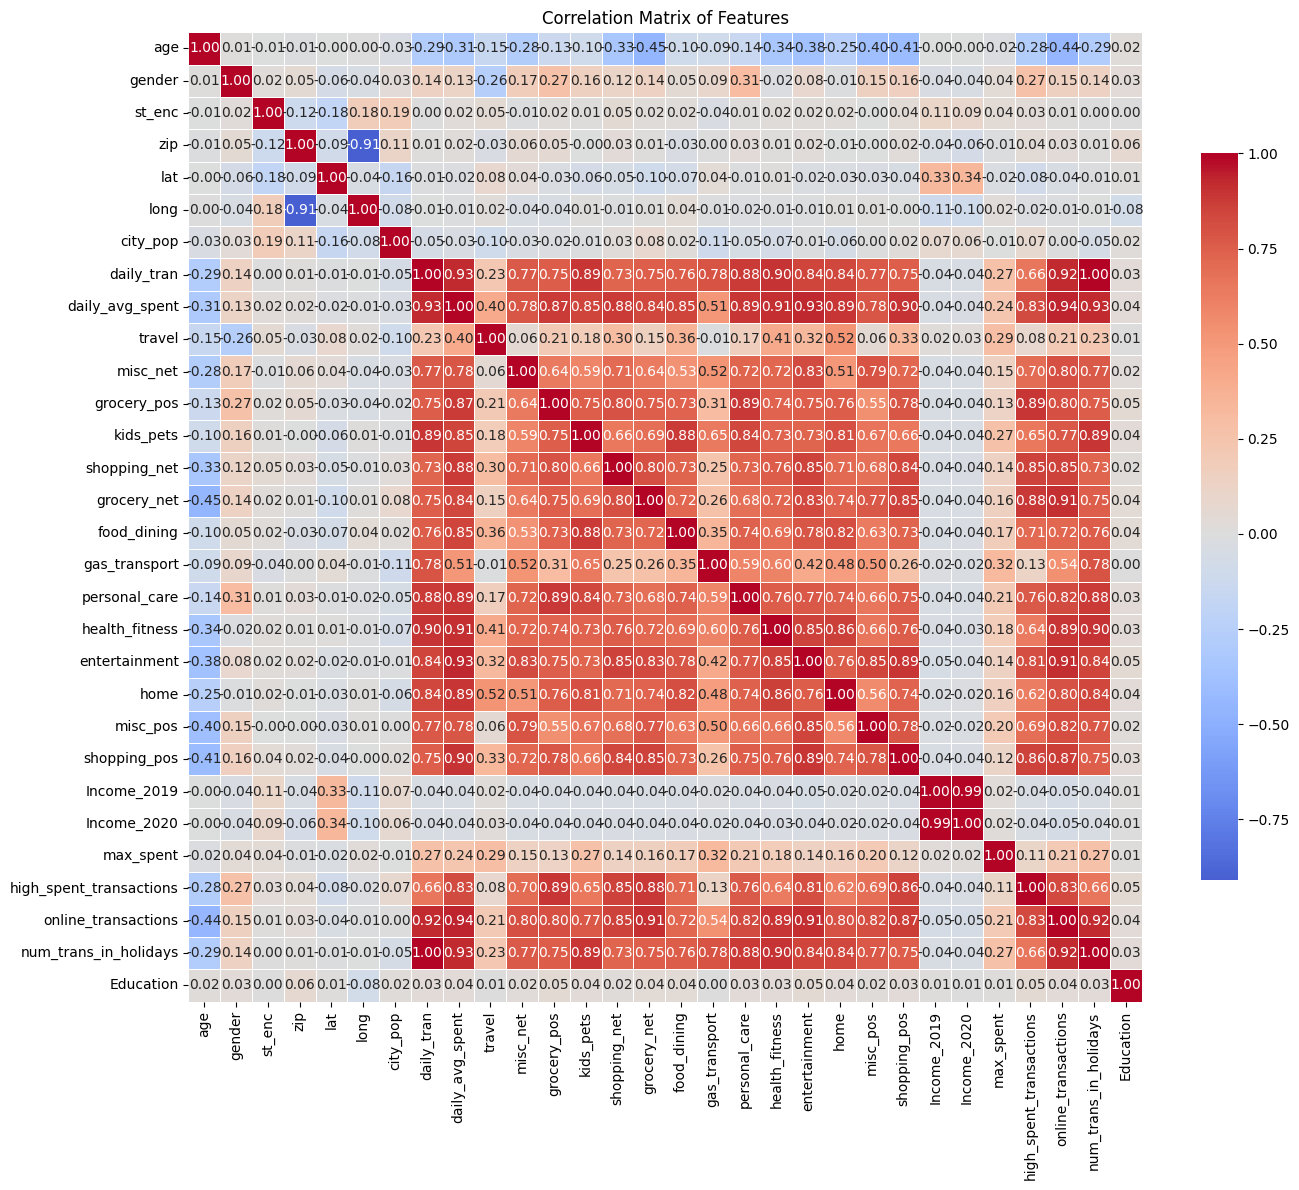

In [ ]:
# Visualization
correlation_pd = pd.DataFrame(correlation_matrix.toArray(), columns=[feature for feature in df_cu.columns if feature not in ['cc_num', 'job']], index= [feature for feature in df_cu.columns if feature not in ['cc_num', 'job']])
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_pd, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, center=0, cbar_kws={'shrink': 0.75})
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

#### Outlier detection with Isolation Forest

In [ ]:
# 'cc_num' is categorical
df_customer = df_customer.select('cc_num','age', 'gender', 'st_enc','city_pop', 'zip', 'lat', 'long',
                        'daily_tran','daily_avg_spent','Income_2019','Income_2020', 'max_spent',
                        'high_spent_transactions', 'online_transactions', 'num_trans_in_holidays', 'Education')

In [ ]:
columns = ['age', 'gender', 'st_enc','city_pop', 'zip', 'lat', 'long',
          'daily_tran','daily_avg_spent','Income_2019','Income_2020', 'max_spent',
           'high_spent_transactions', 'online_transactions', 'num_trans_in_holidays', 'Education']

assembler = VectorAssembler(inputCols=columns, outputCol="features")
df_clust = assembler.transform(df_customer)

isolation_forest = IsolationForest()
isolation_forest.setFeaturesCol("features")
isolation_forest.setPredictionCol("predicted_label")
isolation_forest.setContamination(0.1)
model = isolation_forest.fit(df_clust)
result = model.transform(df_clust)

In [ ]:
result.write.parquet('/content/drive/My Drive/df_customer_outlier_score.parquet')

In [ ]:
df_customer_out = spark.read.parquet('/content/drive/My Drive/DF_MP/df_customer_outlier_score.parquet', header = True, inferSchema = True)

In [ ]:
df_outliers = df_customer_out.filter(df_customer.predicted_label == 1)
df_inliers = df_customer_out.filter(df_customer.predicted_label == 0)
df_inliers.describe().show()
df_outliers.describe().show()
#Apparently there are no reasons for considering these cardholders outliers

+-------+--------------------+------------------+------------------+--------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------------+-------------------+---------------------+------------------+-------------------+---------------+
|summary|              cc_num|               age|            gender|              st_enc|          city_pop|              zip|               lat|              long|        daily_tran|   daily_avg_spent|       Income_2019|      Income_2020|         max_spent|high_spent_transactions|online_transactions|num_trans_in_holidays|         Education|       outlierScore|predicted_label|
+-------+--------------------+------------------+------------------+--------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+-

####**Clustering without edu**

In [ ]:
columns_to_drop = ['features', 'outliersScore', 'predicted_label']
df_customer_out = df_customer_out.drop(*columns_to_drop)

In [ ]:
# Normalizing data using MinMaxScaler
columns = ['age', 'gender', 'st_enc','city_pop', 'zip', 'lat', 'long',
          'daily_tran','daily_avg_spent','Income_2019', 'max_spent',
           'high_spent_transactions', 'online_transactions', 'num_trans_in_holidays']

assembler = VectorAssembler(inputCols=columns, outputCol='features')
df_assembled = assembler.transform(df_customer_out)
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(df_assembled)
normalized_data = scaler_model.transform(df_assembled)

In [ ]:
k_values = range(2, 20)
sse_list = []
silhouette_list = []

for k in k_values:
    kmeans = KMeans(k=k, seed=1, featuresCol="scaledFeatures", predictionCol="prediction")
    model = kmeans.fit(normalized_data)
    sse = model.summary.trainingCost
    sse_list.append(sse)
    predictions = model.transform(normalized_data)
    evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", predictionCol="prediction", metricName="silhouette")
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)

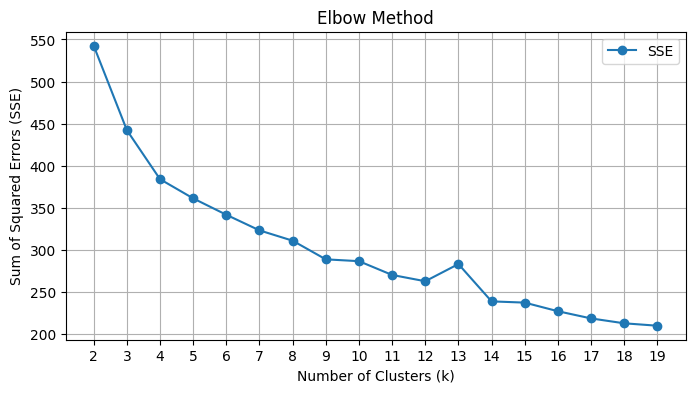

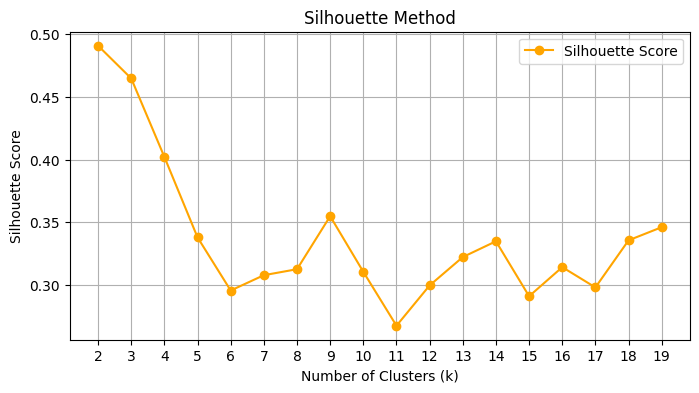

In [ ]:
# Elbow graph
plt.figure(figsize=(8, 4))
plt.plot(k_values, sse_list, marker='o', label='SSE')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

# Plot Silhouette
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_list, marker='o', color='orange', label='Silhouette Score')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
kmeans = KMeans(k=5, seed=1, featuresCol="scaledFeatures", predictionCol="cluster")
model = kmeans.fit(normalized_data)
clustered_data = model.transform(normalized_data)

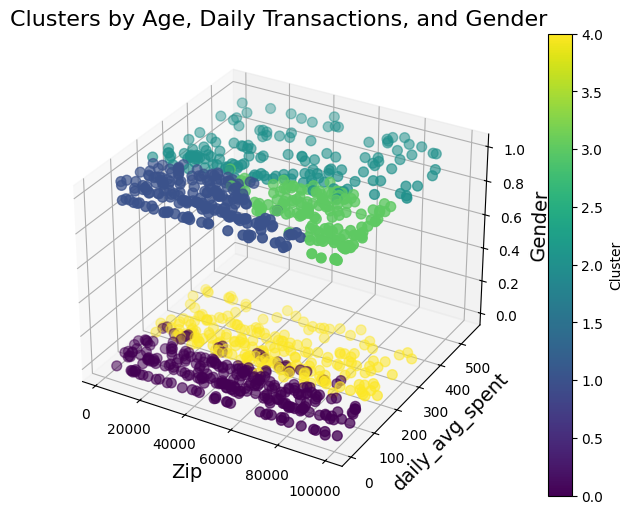

In [ ]:
pandas_data = clustered_data.select("zip", "daily_avg_spent", "gender", "cluster").toPandas()

# Visualization
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot
scatter = ax.scatter(
    pandas_data["zip"],
    pandas_data["daily_avg_spent"],
    pandas_data["gender"],
    c=pandas_data["cluster"],
    cmap="viridis",
    s=50  )

ax.set_title("Clusters by Age, Daily Transactions, and Gender", fontsize=16)
ax.set_xlabel("Zip", fontsize=14)
ax.set_ylabel("daily_avg_spent", fontsize=14)
ax.set_zlabel("Gender", fontsize=14)
fig.colorbar(scatter, label="Cluster")

plt.grid(True)
plt.show()

####**Clustering with edu**

In [ ]:
columns = ['age', 'gender', 'st_enc','city_pop', 'zip', 'lat', 'long',
          'daily_tran','daily_avg_spent','Income_2019', 'max_spent',
           'high_spent_transactions', 'online_transactions', 'num_trans_in_holidays', 'Education']

assembler_edu = VectorAssembler(inputCols=columns, outputCol='features')
df_assembled_edu = assembler_edu.transform(df_customer_out)
scaler_edu = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(df_assembled_edu)
normalized_data_edu = scaler_model.transform(df_assembled_edu)

In [ ]:
k_values = range(2, 20)
sse_list = []
silhouette_list = []

for k in k_values:
    kmeans = KMeans(k=k, seed=1, featuresCol="scaledFeatures", predictionCol="prediction")
    model = kmeans.fit(normalized_data_edu)
    sse = model.summary.trainingCost
    sse_list.append(sse)
    predictions = model.transform(normalized_data_edu)

    evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", predictionCol="prediction", metricName="silhouette")
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)

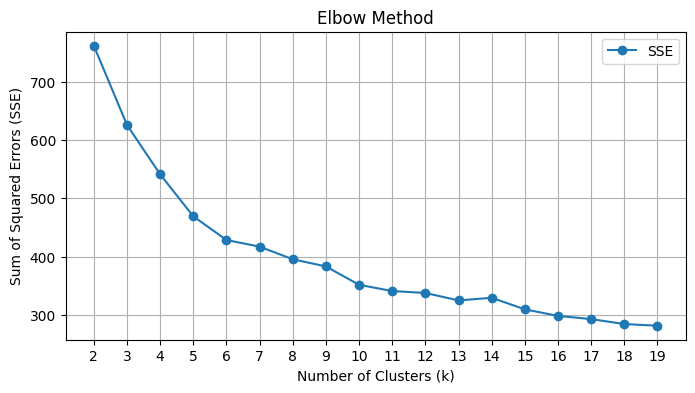

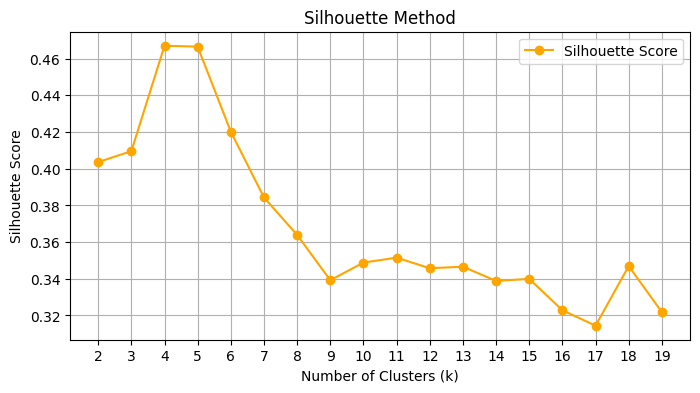

In [ ]:
# Plot SSE
plt.figure(figsize=(8, 4))
plt.plot(k_values, sse_list, marker='o', label='SSE')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

# Plot Silhouette
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_list, marker='o', color='orange', label='Silhouette Score')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
kmeans = KMeans(k=6, seed=1, featuresCol="scaledFeatures", predictionCol="cluster")
model_edu = kmeans.fit(normalized_data_edu)
clustered_data_edu = model_edu.transform(normalized_data_edu)

In [ ]:
data = clustered_data_edu.select("Education", "daily_avg_spent", "gender", "cluster").collect()
plot_data = [Row.asDict(row) for row in data]

education = [row["Education"] for row in plot_data]
daily_avg_spent = [row["daily_avg_spent"] for row in plot_data]
gender = [row["gender"] for row in plot_data]
cluster = [row["cluster"] for row in plot_data]

# Visualization
scatter = Scatter3d(
    x=education,
    y=daily_avg_spent,
    z=gender,
    mode='markers',
    marker=dict(
        size=5,
        color=cluster,
        colorscale='Viridis',
        opacity=0.8
    ),
    hovertemplate="Education: %{x}<br>Daily Avg Spent: %{y}<br>Gender: %{z}<br>Cluster: %{marker.color}"
)

title=dict(
        text="Clusters by Education, Gender, and Daily AVG Spent",
        x=0.5,
        y=0.4,
        xanchor='center',
        yanchor='top'
)
layout = dict(
    title="Clusters by Education, Gender, and Daily AVG Spent",
    scene=dict(
        xaxis=dict(title="Education"),
        yaxis=dict(title="Daily AVG Spent"),
        zaxis=dict(title="Gender"),

    ),
    width=500,
    height=500,
    margin=dict(l=5, r=5, t=30, b=5)  # Reduce margins: left, right, top, bottom

)

fig = Figure(data=[scatter], layout=layout)
fig.show()

In [ ]:
clustered_data_edu.groupBy('cluster').agg(count('*').alias('count')).show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|  211|
|      3|  144|
|      5|  139|
|      4|  147|
|      2|  171|
|      0|  171|
+-------+-----+



#### **clustering with correlated features**

In [ ]:
df_customer = spark.read.parquet('/content/drive/My Drive/df_customer.parquet', header = True, inferSchema = True)

In [ ]:
# education from str to int
df_customer = df_customer.withColumn("Education", df_customer["Education"].cast("int"))

In [ ]:
assembler_tot = VectorAssembler(inputCols=
[feature for feature in df_customer.columns if feature not in ['job', 'cc_num']], outputCol='features')
df_assembled_tot = assembler_tot.transform(df_customer)
scaler_tot = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler_tot.fit(df_assembled_tot)
normalized_data_tot = scaler_model.transform(df_assembled_tot)

In [ ]:
k_values = range(2, 20)
sse_list_tot = []
silhouette_list_tot = []

for k in k_values:

    kmeans = KMeans(k=k, seed=1, featuresCol="scaledFeatures", predictionCol="prediction")
    model = kmeans.fit(normalized_data_tot)
    sse = model.summary.trainingCost
    sse_list_tot.append(sse)
    predictions = model.transform(normalized_data_tot)

    evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", predictionCol="prediction", metricName="silhouette")
    silhouette = evaluator.evaluate(predictions)
    silhouette_list_tot.append(silhouette)

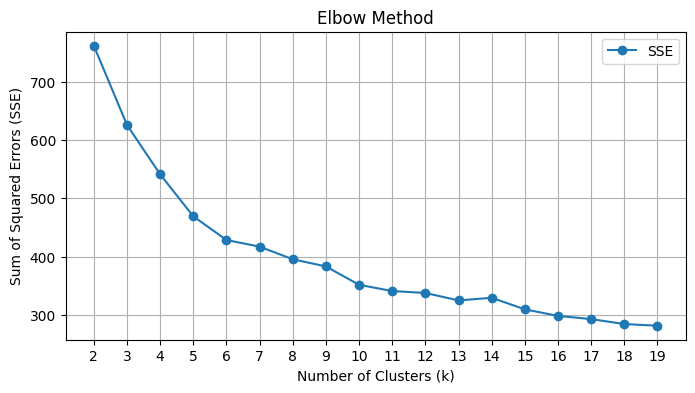

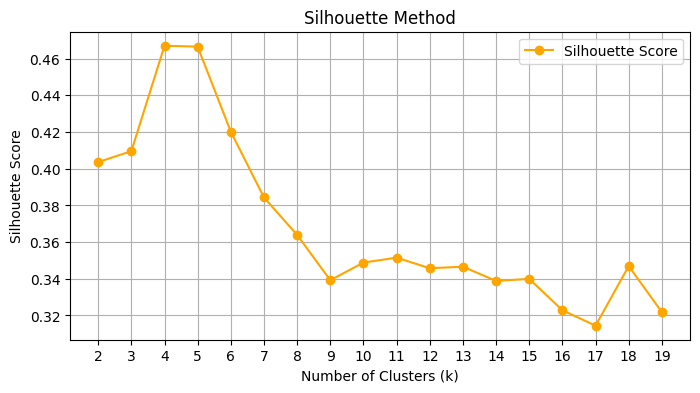

In [ ]:
# Plot SSE
plt.figure(figsize=(8, 4))
plt.plot(k_values, sse_list, marker='o', label='SSE')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

# Plot Silhouette
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_list, marker='o', color='orange', label='Silhouette Score')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
kmeans = KMeans(k=5, seed=1, featuresCol="scaledFeatures", predictionCol="cluster")
model = kmeans.fit(normalized_data_tot)
clustered_data_tot = model.transform(normalized_data_tot)

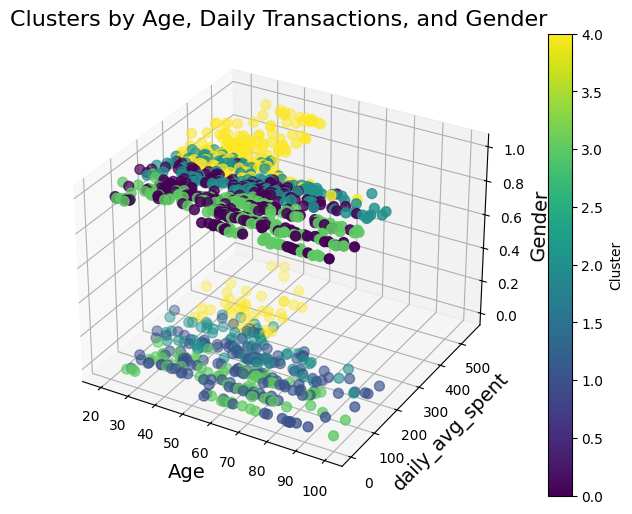

In [ ]:
pandas_data = clustered_data_tot.select("age", "daily_avg_spent", "Education", "cluster").toPandas()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

#Visualization
scatter = ax.scatter(
    pandas_data["age"],
    pandas_data["daily_avg_spent"],
    pandas_data["Education"],
    c=pandas_data["cluster"],
    cmap="viridis",
    s=50
)


ax.set_title("Clusters by Age, Daily Transactions, and Gender", fontsize=16)
ax.set_xlabel("Age", fontsize=14)
ax.set_ylabel("daily_avg_spent", fontsize=14)
ax.set_zlabel("Gender", fontsize=14)
fig.colorbar(scatter, label="Cluster")

plt.grid(True)
plt.show()

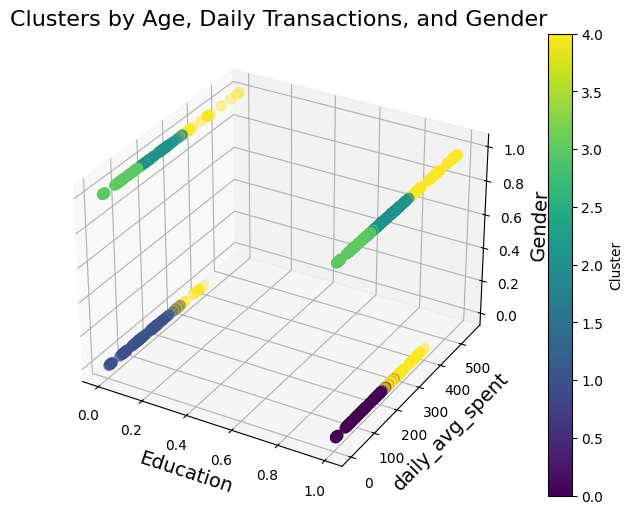

In [ ]:
pandas_data = clustered_data_tot.select("Education", "daily_avg_spent", "gender", "cluster").toPandas()
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Visualization
scatter = ax.scatter(
    pandas_data["Education"],
    pandas_data["daily_avg_spent"],
    pandas_data["gender"],
    c=pandas_data["cluster"],
    cmap="viridis",
    s=50
)

ax.set_title("Clusters by Age, Daily Transactions, and Gender", fontsize=16)
ax.set_xlabel("Education", fontsize=14)
ax.set_ylabel("daily_avg_spent", fontsize=14)
ax.set_zlabel("Gender", fontsize=14)
fig.colorbar(scatter, label="Cluster")

plt.grid(True)
plt.show()

In [ ]:
clustered_data_tot.groupBy('cluster').agg(count('*').alias('count')).show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|  150|
|      3|  217|
|      4|  180|
|      2|  205|
|      0|  231|
+-------+-----+



# **Behavioural Analysis**

In [ ]:
clustered_data = clustered_data.select('cc_num', 'cluster')
df_be = df.join(clustered_data, on='cc_num', how='left')

In [ ]:
df_be.write.parquet('/content/drive/My Drive/df_be.parquet')

In [ ]:
df_be = spark.read.parquet('/content/drive/My Drive/DF_MP/df_be.parquet', header = True, inferSchema = True)
df_be= df_be.withColumn('gender', when(col('gender') == 0, 'M').when(col('gender') == 1, 'F'))
categories = df_be.select('category').distinct().rdd.flatMap(lambda x: x).collect()

In [ ]:
total_spent_by_gender = df_be.groupBy('gender').agg(
    round(sum('amt'), 2).alias('total_spent'))

# Visualization
data = total_spent_by_gender.collect()
gender = [row['gender'] for row in data]
total_spent = [row['total_spent'] for row in data]

fig = go.Figure(data=go.Bar(x=gender, y=total_spent, marker=dict(color=total_spent, colorscale="greens"),))
fig.update_layout(
    title="Total Amount Spent by gender",
    xaxis_title="Gender",
    yaxis_title="Total Amount Spent",
    xaxis_tickangle=45,
    template="plotly_dark",
    width=600,
    height=400
)
fig.show()

In [ ]:
total_spent_by_state= df_be.groupBy("state").agg(round(sum("amt"), 2).alias("total_spent"))

# Visualization
data = total_spent_by_state.collect()
states = [row['state'] for row in data]
total_spent = [row['total_spent'] for row in data]

fig = go.Figure(data=go.Bar(x=states, y=total_spent, marker=dict(color=total_spent, colorscale="greens"),))
fig.update_layout(
    title="Total Amount Spent in Each State",
    xaxis_title="State",
    yaxis_title="Total Amount Spent",
    xaxis_tickangle=45,
    template="plotly_white",)
fig.show()

In [ ]:
total_transaction_by_month = df_be.groupBy('month', 'year').agg(count('*').alias('count')).orderBy('year', 'month')
data = total_transaction_by_month.collect()
months = [row['month'] for row in data]
years = [row['year'] for row in data]
counts = [row['count'] for row in data]



labels = [f"{month}/{year}" for month, year in zip(months, years)]

x_numeric = np.arange(len(months)).reshape(-1, 1)
y_values = np.array(counts).reshape(-1, 1)

# Linear regression for plotting the trend line
model = LinearRegression()
model.fit(x_numeric, y_values)
trendline = model.predict(x_numeric).flatten()

fig = go.Figure()

# Actual data
fig.add_trace(
    go.Scatter(
        x=labels,
        y=counts,
        mode="lines+markers",
        name="Total Transactions",
        line=dict(color="blue", width=2),
        marker=dict(size=6),
    )
)

# Trendline
fig.add_trace(
    go.Scatter(
        x=labels,
        y=trendline,
        mode="lines",
        name="Trendline",
        line=dict(color="red", dash="dash", width=2),
    )
)

deviation = np.array(counts) - trendline
deviation_text = ["H" if d > 0 else "L" for d in deviation]

for i, label in enumerate(labels):
    fig.add_trace(
        go.Scatter(
            x=[label],
            y=[counts[i]],
            mode="markers+text",
            text=[deviation_text[i]],
            textposition="top center",
            marker=dict(color="green" if deviation[i] > 0 else "orange", size=8),
            showlegend=False,
        )
    )

fig.update_layout(
    title="Total Transactions by Month with Trendline",
    xaxis=dict(
        title="Month/Year",
        tickangle=45,
    ),
    yaxis=dict(
        title="Number of Transactions",
    ),
    template="plotly_white",
    height=500,
    width=800,
)

fig.show()

In [ ]:
total_transaction_by_hour = df_be.groupBy('hour').agg(count('*').alias('count')).orderBy('hour')
data = total_transaction_by_hour.collect()
hours = [row['hour'] for row in data]
counts = [row['count'] for row in data]
labels = [f"{hour}" for hour in hours]

# Visualization with line chart
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=labels,
        y=counts,
        mode="lines+markers",
        name="Total Transactions",
        line=dict(color="blue", width=2),
        marker=dict(size=6),
    )
)


fig.update_layout(
    title="Total Transactions by Hour",
    xaxis=dict(
        title="Hour",
        tickangle=45,
    ),
    yaxis=dict(
        title="Number of Transactions",
    ),
    template="plotly_white",
    height=500,
    width=800,
)
fig.show()

In [ ]:
filtered_df = df_be.filter(col('category') == 'personal_care')
total_transaction_by_hour = filtered_df.groupBy('hour').agg(count('*').alias('count')).orderBy('hour')

#Visualization
data = total_transaction_by_hour.collect()
hours = [row['hour'] for row in data]
counts = [row['count'] for row in data]
labels = [f"{hour}" for hour in hours]

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=labels,
        y=counts,
        mode="lines+markers",
        name="Total Transactions",
        line=dict(color="blue", width=2),
        marker=dict(size=6),))

fig.update_layout(
    title="Total Transactions by Hour for \"Personal Care\"",
    xaxis=dict(
        title="Hour",
        tickangle=45,
    ),
    yaxis=dict(
        title="Number of Transactions",
    ),
    template="plotly_white",
    height=500,
    width=800,
)
fig.show()

In [ ]:
clusters = {
    "Low_edu_m": 0,
    "Low_spend_High_edu_f": 1,
    "Low_spend_High_edu_m": 2,
    "High_spend_High_edu_m": 3,
    "High_spend_w": 4,
    "Low_spend_Low_edu_f": 5,
}

spending_per_category = {}
percentage_spending_per_category = {}
categories = df_be.select("category").distinct().rdd.flatMap(lambda x: x).collect() # collecting unique categories

# Aggregate spending per category for each cluster
for cluster, cluster_id in clusters.items():
    spending_per_category[cluster] = {}
    for category in categories:
        total_spent = df_be.filter(
            (col("cluster") == cluster_id) & (col("category") == category)
        ).groupBy("category").agg(sum("amt").alias("total_spent")).collect()

        spending_per_category[cluster][category] = total_spent[0]["total_spent"] if total_spent else 0


# Normalizing spending to percentages
percentage_spending_per_category = {}
for cluster, spending_data in spending_per_category.items():
  total_spent_in_group = 0
  for value in spending_data.values():
    total_spent_in_group += value
    percentage_spending_per_category[cluster] = {
        category: (amount / total_spent_in_group) * 100 if total_spent_in_group != 0 else 0
        for category, amount in spending_data.items()}


# Visualization
fig = go.Figure()
width = 0.12
x = list(range(len(categories)))

for i, (cluster, percentage_data) in enumerate(percentage_spending_per_category.items()):
    fig.add_trace(
        go.Bar(
            x=[pos + i * width for pos in x],
            y=list(percentage_data.values()),
            name=cluster,
            width=width,
        ))

fig.update_layout(
    title="Percentage Spending per Category by Cluster",
    xaxis=dict(
        title="Category",
        tickvals=[pos + (width * (len(clusters) - 1) / 2) for pos in x],
        ticktext=categories,
        tickangle=45,),
    yaxis=dict(title="Percentage Spent (%)"),
    barmode="group",
    template="plotly_white",)

fig.show()

In [ ]:
age_groups = {
    "Under 30": (0, 30),
    "30-60": (30, 60),
    "Over 60": (60, float('inf'))
}

spending_per_category = {}
percentage_spending_per_category = {}
categories = df_be.select("category").distinct().rdd.flatMap(lambda x: x).collect()

for age_group, (min_age, max_age) in age_groups.items():
    spending_per_category[age_group] = {}
    for category in categories:
        total_spent = df_be.filter(
            (col("age") >= min_age) & (col("age") < max_age) & (col("category") == category)
        ).groupBy("category").agg(sum("amt").alias("total_spent")).collect()

        spending_per_category[age_group][category] = total_spent[0]["total_spent"] if total_spent else 0

percentage_spending_per_category = {}
for age_group, spending_data in spending_per_category.items():
  total_spent_in_group = 0
  for value in spending_data.values():
    total_spent_in_group += value
    percentage_spending_per_category[age_group] = {
        category: (amount / total_spent_in_group) * 100 if total_spent_in_group != 0 else 0
        for category, amount in spending_data.items()
    }

#Visualization
fig = go.Figure()
width = 0.2  # Bar
x = list(range(len(categories)))

for i, (age_group, percentage_data) in enumerate(percentage_spending_per_category.items()):
    fig.add_trace(go.Bar(
            x=[pos + i * width for pos in x],
            y=list(percentage_data.values()),
            name=age_group,
            hoverinfo="x+y",))

fig.update_layout(title="Percentage Spending per Category by Age Group",
    xaxis=dict(
        title="Category",
        tickvals=[pos + (width * len(age_groups) / 2) for pos in x],
        ticktext=categories,
        tickangle=45,),
    yaxis=dict(title='Percentage Spent %'),
    barmode="group",
    template="plotly_white")
fig.show()

# **Classification**

In [ ]:
# import random forest
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import random
from imblearn.over_sampling import SMOTE
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, jaccard_score

In [ ]:
ML_df = spark.read.parquet('/content/drive/My Drive/DF_MP/ML_df.parquet', header = True, inferSchema = True)

In [ ]:
ML_df = ML_df.fillna(0)

assembler = VectorAssembler(inputCols=[col for col in ML_df.columns if col != 'is_fraud'],
                            outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

pipeline = Pipeline(stages=[assembler, scaler])

pipeline_model = pipeline.fit(ML_df)

ML_df_transormed = pipeline_model.transform(ML_df)
ML_df_transormed = ML_df_transormed.drop('features')

# Stratified
fractions = {0: 0.8, 1: 0.8}  # Class 0 (non-fraud) and class 1 (fraud)
train_df, val_df = ML_df_transormed.sampleBy("is_fraud", fractions, seed=42).randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Oversampling minority
def oversample_minority(df, ratio):
    minority_count = df.filter('is_fraud == 1 ').count()
    majority_count = df.filter('is_fraud == 0').count()

    balance_ratio = majority_count / minority_count

    print(f"Initial Majority:Minority ratio is {balance_ratio:.2f}:1")

    if ratio >= balance_ratio:
        print("No oversampling of minority was done as the input ratio was more than or equal to the initial ratio.")
    else:
        print(f"Oversampling of minority done such that Majority:Minority ratio is {ratio}:1")

    oversampled_minority = df.filter('is_fraud ==1')\
                                .sample(withReplacement=True, fraction=(balance_ratio/ratio),seed=88)
    oversampled_df = df.filter('is_fraud == 0').union(oversampled_minority)

    return oversampled_df

In [ ]:
train_df_1_5 = oversample_minority(train_df,5)
train_df_1_7 = oversample_minority(train_df,7)

In [ ]:
train_df_1_5.write.parquet('/content/drive/My Drive/DF_MP/train_df_1_5.parquet')
train_df_1_7.write.parquet('/content/drive/My Drive/DF_MP/train_df_1_7.parquet')

In [ ]:
train_df_1_5 = spark.read.parquet('/content/drive/My Drive/DF_MP/train_df_1_5.parquet', header = True, inferSchema = True)
train_df_1_7 = spark.read.parquet('/content/drive/My Drive/DF_MP/train_df_1_7.parquet', header = True, inferSchema = True)

### **Training**

In [ ]:
MODELS = {}
EVALUATIONS = {}

Random Search for Logistic Regression 1:5


In [ ]:
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="is_fraud")

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [50, 100, 200]) \
    .build()

random_subset = random.sample(paramGrid, 10)  # Only 10 combinations
evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", metricName="areaUnderROC")
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=random_subset,
                    evaluator=evaluator,
                    numFolds=5,
                    seed=42)

cvModel = cv.fit(train_df_1_5)
bestModel = cvModel.bestModel
MODELS['LR_1_5'] = bestModel

Random Search for Random Forest sampling 1:5

In [ ]:
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="is_fraud")
paramGrid = paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15, 20]) \
    .addGrid(rf.maxBins, [16, 32, 64]) \
    .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt", "log2"]) \
    .build()

random_subset = random.sample(paramGrid, 7)  # 7 combinations

evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", metricName="areaUnderROC")

cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=random_subset,
                    evaluator=evaluator,
                    numFolds=5,
                    seed=42)

cvModel = cv.fit(train_df_1_5)
bestModel = cvModel.bestModel
MODELS['RF_1_5'] = bestModel

In [ ]:
best_params = bestModel.extractParamMap()
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Best Parameters:
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: scaledFeatures
impurity: gini
labelCol: is_fraud
leafCol: 
maxBins: 32
maxDepth: 15
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 10
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 6862184814970853269
subsamplingRate: 1.0


Random Search for Logistic Regression 1:7


In [ ]:
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="is_fraud")

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [50, 100, 200]) \
    .build()

random_subset = random.sample(paramGrid, 7)
evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", metricName="areaUnderROC")
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=random_subset,
                    evaluator=evaluator,
                    numFolds=5,
                    seed=42)

cvModel = cv.fit(train_df_1_7)
bestModel = cvModel.bestModel
MODELS['LR_1_7'] = bestModel

Random Search for Random Forest 1:7

In [ ]:
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="is_fraud")

paramGrid = paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15, 20]) \
    .addGrid(rf.maxBins, [16, 32, 64]) \
    .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt", "log2"]) \
    .build()

random_subset = random.sample(paramGrid, 7)

evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", metricName="areaUnderROC")
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=random_subset,
                    evaluator=evaluator,
                    numFolds=5,
                    seed=42)

cvModel = cv.fit(train_df_1_7)

bestModel_rf_1_7 = cvModel.bestModel
MODELS['RF_1_7'] = bestModel_rf_1_7

### **Validation**

In [ ]:
# Evaluation
def evaluator(prediction):
  predictions_and_labels = prediction.select("prediction", "is_fraud").collect()
  y_true = [row["is_fraud"] for row in predictions_and_labels]
  y_pred = [row["prediction"] for row in predictions_and_labels]

  conf_matrix = confusion_matrix(y_true, y_pred)

  precision = precision_score(y_true, y_pred, zero_division=0)
  recall = recall_score(y_true, y_pred, zero_division=0)
  f1 = f1_score(y_true, y_pred, zero_division=0)
  g_measure = np.sqrt(precision*recall)
  jaccard_index = jaccard_score(y_true, y_pred, zero_division=0)
  roc_auc = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="probability", metricName="areaUnderROC").evaluate(prediction)

  metrics = {
      "confusion_matrix": conf_matrix.tolist(),
      "precision": precision,
      "recall": recall,
      "f1_score": f1,
      "g-measure": g_measure,
      "jaccard_index": jaccard_index,
      "roc_auc": roc_auc}

  return metrics

In [ ]:
lr = LogisticRegression(
    aggregationDepth=2,
    elasticNetParam=0.5,
    family="auto",
    featuresCol="scaledFeatures",
    fitIntercept=True,
    labelCol="is_fraud",
    maxBlockSizeInMB=0.0,
    maxIter=50,
    predictionCol="prediction",
    probabilityCol="probability",
    rawPredictionCol="rawPrediction",
    regParam=0.01,
    standardization=True,
    threshold=0.5,
    tol=1e-06 )



model = lr.fit(train_df_1_5)
predictions_1_5 = model.transform(val_df)
evaluations = evaluator(predictions_1_5)
EVALUATIONS['LR_1_5'] = evaluations

In [ ]:
model = MODELS['RF_1_5']
predictions_1_5 = model.transform(val_df)
evaluations = evaluator(predictions_1_5)
EVALUATIONS['RF_1_5'] = evaluations

In [ ]:
EVALUATIONS

{'LR_1_5': {'confusion_matrix': [[204451, 1696], [538, 626]],
  'precision': 0.2695951765719208,
  'recall': 0.5378006872852233,
  'f1_score': 0.3591508892713712,
  'g-measure': 0.38077351700080214,
  'jaccard_index': 0.21888111888111889,
  'roc_auc': 0.877307258656065},
 'RF_1_5': {'confusion_matrix': [[205962, 185], [274, 890]],
  'precision': 0.827906976744186,
  'recall': 0.7646048109965635,
  'f1_score': 0.7949977668602054,
  'g-measure': 0.7956265816802658,
  'jaccard_index': 0.6597479614529281,
  'roc_auc': 0.9874755364657628}}

In [ ]:
'''
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: sqrt
featuresCol: scaledFeatures
impurity: gini
labelCol: is_fraud
leafCol:
maxBins: 64
maxDepth: 20
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 50
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: -4896389868022556071
subsamplingRate: 1.0
'''

model = MODELS['RF_1_7']
predictions_1_7 = model.transform(val_df)
evaluations = evaluator(predictions_1_7)
EVALUATIONS['RF_1_7'] = evaluations

In [ ]:
EVALUATIONS

{'RF_1_7': {'confusion_matrix': [[206079, 68], [261, 903]],
  'precision': 0.9299691040164778,
  'recall': 0.7757731958762887,
  'f1_score': 0.8459016393442623,
  'g-measure': 0.8493792462081186,
  'jaccard_index': 0.7329545454545454,
  'roc_auc': 0.9920551576672416}}

#### Experiments with pandas

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
train_pd = train_df.toPandas()
val_df = val_df.toPandas()

X = train_pd.drop(['is_fraud', 'scaledFeatures'], axis=1).values
y = train_pd['is_fraud'].values

smote = SMOTE(sampling_strategy= 0.4, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

X_val= val_df.drop(['is_fraud', 'scaledFeatures'], axis=1).values
y_val = val_df['is_fraud'].values

In [ ]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.9979499399452996
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    206147
           1       0.86      0.76      0.81      1164

    accuracy                           1.00    207311
   macro avg       0.93      0.88      0.90    207311
weighted avg       1.00      1.00      1.00    207311

